In [1]:
import pandas as pd
from scipy import special, integrate
import numpy as np
from yahoo_fin import options
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

In [2]:
plt.style.use('fivethirtyeight')

In [28]:
global dist_type
global theta
global sigma
global kappa
global mu
global r
global T
global S
global c_mkt
global K

In [29]:
def CharFunc(u, params, type, dt):

    if type == 1: # Gaussian distribution
        mu, sigma = params[0], params[1]
        return np.exp(dt*(1j * u * mu - 0.5 * (sigma**2) * (u**2)))
    elif type == 2: # Variance Gamma distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt) * (1 - 1j * u * theta * kappa + 0.5 * (u**2) * (sigma**2) * kappa) ** (-dt / kappa)
    elif type == 3: # Normal inverse Gaussian distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt + dt/kappa * (1 - np.sqrt(1 + (u**2) * (sigma**2) * kappa - 2 * 1j * u * theta * kappa)))
    elif type == 4: # CGMY distribution
        mu, C, G, M, Y = params[0], params[1], params[2], params[3], params[4]
        return np.exp(1j * u * mu * dt + C * special.gamma(-Y) * dt * ((M - 1j * u) ** Y - (M**Y) + (G + 1j * u) ** Y - (G**Y)))
    elif type == 5: # Merton Jump Diffusion
        mu, sigma, l, mu_z, sigma_z = params[0], params[1], params[2], params[3], params[4]
        phi_Y = np.exp(1j * u * mu_z - 0.5 * (sigma_z**2) * (u**2))
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 6: # Kou Jump Diffusion
        mu, sigma, l, p, eta1, eta2 = params[0], params[1], params[2], params[3], params[4], params[5]
        q = 1 - p
        phi_Y = p * eta1/(eta1 * 1j * u) + q * eta2/(eta2 * 1j * u)
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 7: # Heston
        mu, sigma, k, neta, theta, rho = params[0], params[1], params[2], params[3], params[4], params[5]
        d = ((rho * theta * u * 1j - k)**2 - (theta**2) * (-1j * u - (u**2))) ** 0.5
        rep = k - rho * theta * u * 1j - d
        g = rep/(rep + 2 * d)
        tmp1 = np.exp(1j * u * mu * dt)
        tmp2 = np.exp(neta * k * (theta**-2) * (rep * dt - 2 * np.log((1 - g * np.exp(-d * dt))/(1 - g))))
        tmp3 = np.exp(sigma * (theta**-2) * rep * (1 - np.exp(-d * dt))/(1 - g * np.exp(-d * dt)))
        return tmp1 * tmp2 * tmp3

In [30]:
def call_option_transform(u, K, R):
    return (K ** (1 - R - 1j * u))/((1 - R - 1j * u) * (- R - 1j * u))

In [44]:
tick = 'AAPL'
exp_date = options.get_expiration_dates(tick)[0]
calls = pd.DataFrame()
calls = options.get_calls(tick)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       47 non-null     object 
 1   Last Trade Date     47 non-null     object 
 2   Strike              47 non-null     float64
 3   Last Price          47 non-null     float64
 4   Bid                 47 non-null     float64
 5   Ask                 47 non-null     float64
 6   Change              47 non-null     float64
 7   % Change            47 non-null     object 
 8   Volume              47 non-null     object 
 9   Open Interest       47 non-null     int64  
 10  Implied Volatility  47 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 4.2+ KB


In [45]:
calls['Implied Volatility'] = calls['Implied Volatility'].str.replace('%', '').astype(float)/100
calls = calls.drop(['Contract Name', 'Last Trade Date', 'Last Price', 'Ask', 'Change', '% Change', 'Volume', 'Open Interest'], axis=1)

In [46]:
def BlackScholesCall(S,K,r,T,sigma):
    d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    BSCall = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return BSCall

In [47]:
stock = yf.Ticker(tick)
price = stock.history(period='1d')
S = price['Close'][0]
r = 0.05
T = (datetime.strptime(exp_date, '%B %d, %Y') - datetime.today()).days/366
for i in range(calls.shape[0]):
    calls.loc[i, 'Calculated Price'] = BlackScholesCall(S, calls.loc[i, 'Strike'], r, T, calls.loc[i, 'Implied Volatility'])

calls['Price delta'] = calls['Bid'] - calls['Calculated Price']
calls

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/1831613591.py:2: RuntimeWarning: invalid value encountered in sqrt
  d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/1831613591.py:3: RuntimeWarning: invalid value encountered in sqrt
  d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/1831613591.py:2: RuntimeWarning: invalid value encountered in sqrt
  d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/1831613591.py:3: RuntimeWarning: invalid value encountered in sqrt
  d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )


,Strike,Bid,Implied Volatility,Calculated Price,Price delta
0,95.0,87.50,4.3750,NaN,NaN
1,100.0,82.50,4.0625,NaN,NaN
2,110.0,71.55,0.0000,NaN,NaN
3,115.0,67.40,3.1875,NaN,NaN
4,120.0,62.35,3.9023,NaN,NaN
5,125.0,57.00,3.2656,NaN,NaN
6,130.0,52.25,2.7656,NaN,NaN
7,135.0,47.30,2.8125,NaN,NaN
8,140.0,42.25,2.7148,NaN,NaN
9,145.0,37.30,1.9531,NaN,NaN


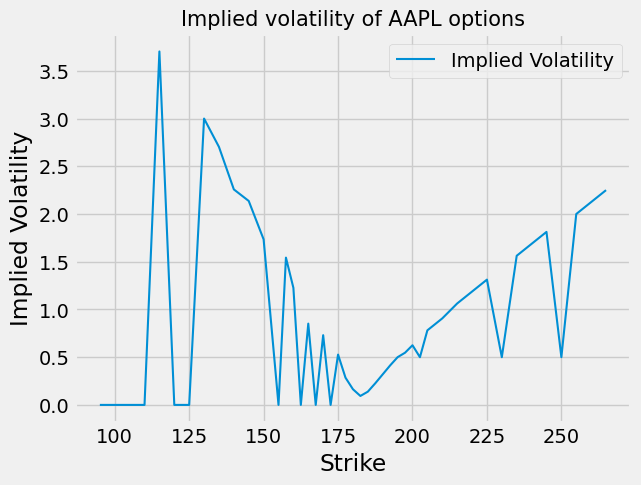

In [9]:
calls.plot('Strike', 'Implied Volatility', linewidth=1.5)
plt.title(f'Implied volatility of {tick} options', fontsize=15)
plt.ylabel('Implied Volatility')
plt.show()

In [10]:
def fourier_pricing(type, params, K, S, r, T):
    R = 1.1
    s = -np.log(S)
    q = 0
    if type == 7:
        omega = 0
    else:
        omega = np.log(CharFunc(-1j, params, type, T))

    mu = r - q - omega
    params[0] = mu

    c_mod = pd.Series()
    for i in range(calls.shape[0]):
        c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) * 
                                                                                        CharFunc(u - 1j * R, params, type, T) * 
                                                                                        call_option_transform(u, K.iloc[i], R)).real, 
                                                                                        0, np.inf)[0]
    return c_mod

In [26]:
def objective_function(init_guess):
    theta, sigma, kappa = init_guess
    c_mod = fourier_pricing(type, [mu, theta, sigma, kappa], K, S, r, T)
    print(c_mod)
    sse = ((c_mkt - c_mod)**2).sum()
    return sse

In [27]:

type = 3
theta = -5
sigma = 7
kappa = 0.4
mu = 0
init_guess = [theta, sigma, kappa]
c_mkt = calls['Bid']
K = calls['Strike']

res = minimize(objective_function, x0=init_guess, method='Nelder-Mead')
print(res)

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/4275728121.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(1j * u * mu * dt + dt/kappa * (1 - np.sqrt(1 + (u**2) * (sigma**2) * kappa - 2 * 1j * u * theta * kappa)))
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/2176318434.py:15: RuntimeWarning: invalid value encountered in cdouble_scalars
  c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) *
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_36242/2176318434.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) *


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
32    NaN
33    NaN
34    NaN
35    NaN
36    NaN
37    NaN
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
45    NaN
46    NaN
dtype: object
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
32    NaN
33    NaN
34    NaN
35    NaN
36    NaN
37    NaN
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
45    NaN
46    NaN
dtype: object
0     NaN
1     NaN
2     NaN
3 